# Smoothing splines offered by SciPy
https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.interpolate import splrep, BSpline

In [4]:
# import data
vel01 = pd.read_csv('data/VDS_지점통행속도_5분_1일_20240601.csv',encoding='cp949')
vel01 = vel01.iloc[:,[2,1,5]]
vel01 = vel01.rename(columns={'집계시분':'time','평균속도':'avgVel'})
vel01 = vel01.sort_values(by=['VDS_ID','time'], ignore_index=True)

# slice the data
data = []
vds = vel01['VDS_ID'].unique()
for i in range(len(vds)):
    data.append(vel01['avgVel'].values[288*i:288*(i+1)])
data = np.array(data)
bMask = [np.any(elem!=-1.0) for elem in data]
data = data[bMask]

# alternatively, pd.cut() can be employed:
# pd.cut(data, 288)

# replace outliers with NaN and fill it with its former value
for i in range(len(data)):
    q5 = np.percentile(data[i], 5, method='midpoint')
    q95 = np.percentile(data[i], 95, method='midpoint')
    for j in range(288):
        if (data[i][j] < q5) | (data[i][j] > q95):
            data[i][j] = np.nan

# convert the list 'data' to pd.Series to apply .fillna()
list_of_series = []
for i in range(len(data)):
    elem_series = pd.Series(data[i])
    elem_series = elem_series.ffill()
    elem_series = elem_series.bfill()
    list_of_series.append(elem_series.tolist())
data = np.array(list_of_series)

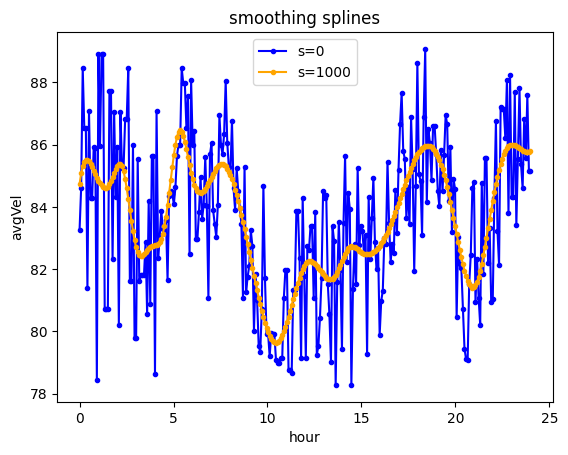

In [47]:
# test - construct a spline
h = np.linspace(0,24,288)
tck = splrep(h, data[0], s=1000)
plt.plot(h, data[0],'.-',color='blue', label='s=0')
plt.plot(h, BSpline(*tck)(h), '.-',color='orange',label='s=1000')
plt.xlabel('hour')
plt.ylabel('avgVel')
plt.title('smoothing splines')
plt.legend()
plt.show()

In [38]:
# compare spline with different s values
test_s = list(range(500,1500,100))
len(test_s)

10

In [40]:
def draw_pattern(arr):
    row = int(np.ceil(len(arr)/5))
    col = 5
    fig, axs = plt.subplots(row,col,sharex=True, sharey=True)
    plt.tight_layout()
    for i in range(row):
        for j in range(col):
            if i*col + j < len(arr):
                axs[i][j].plot(range(len(arr[col*i+j])), arr[col*i+j])
                axs[i][j].set_title(col*i+j)

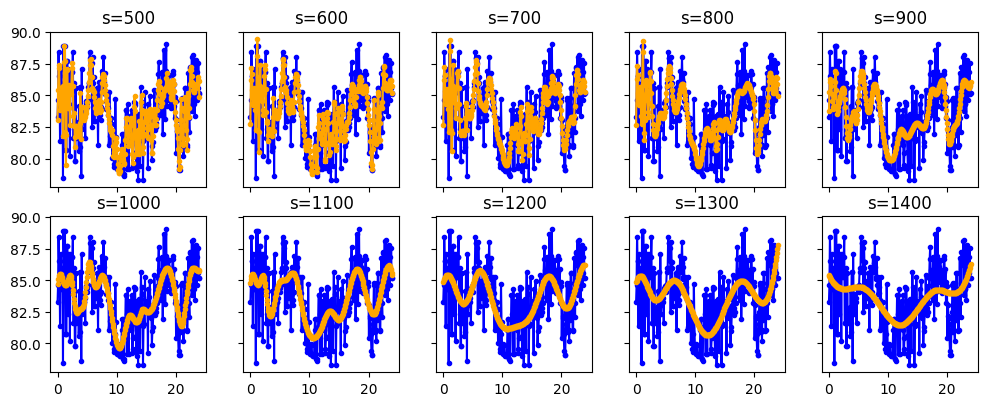

In [44]:
h = np.linspace(0,24,288)
y = []
for i in test_s:
    temp_tick = splrep(h, data[0], s=i)
    y.append(BSpline(*temp_tick)(h))

# plot them all
row = 2
col = 5
fig, axs = plt.subplots(row,col,sharex=True, sharey=True,figsize=(10,4))
plt.tight_layout()
for i in range(row):
    for j in range(col):
        axs[i][j].plot(h, data[0],'.-',color='blue', label='s=0')
        axs[i][j].plot(h, y[col*i+j],'.-',color='orange',label='s=270')
        axs[i][j].set_title(f"s={test_s[col*i+j]}")      

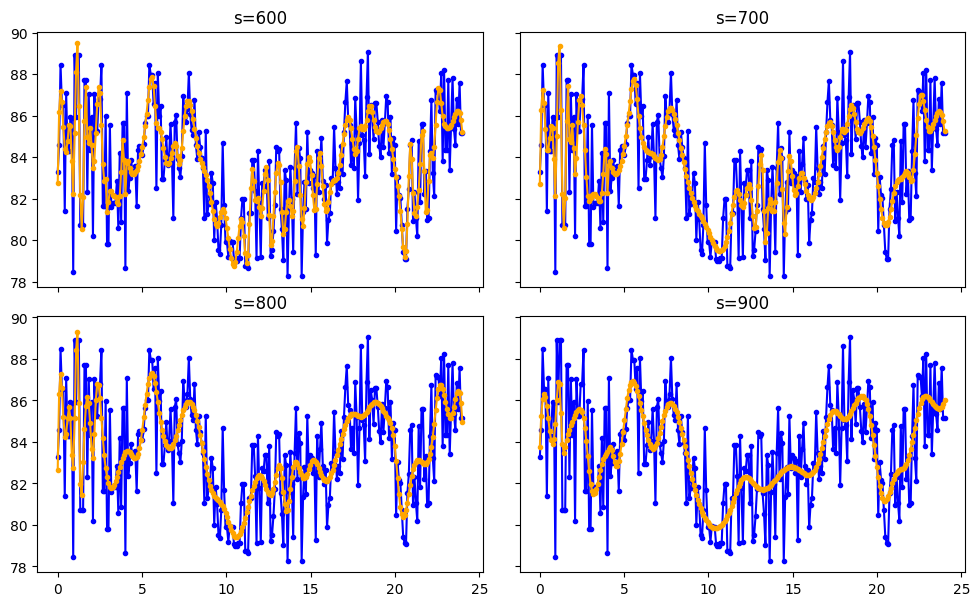

In [52]:
fig, axs = plt.subplots(2,2,sharex=True, sharey=True,figsize=(10,6))
plt.tight_layout()
startIdx = 1
for i in range(2):
    for j in range(2):
        axs[i][j].plot(h, data[0],'.-',color='blue', label='s=0')
        axs[i][j].plot(h, y[startIdx],'.-',color='orange',label='s=270')
        axs[i][j].set_title(f"s={test_s[startIdx]}")
        startIdx += 1

# go with s=800; values less than this give an warning.

In [55]:
# turning back to our data, apply this method to each element of data
data_sp = []
for i in range(len(data)):
    tck = splrep(h, data[i], s=800)
    data_sp.append(BSpline(*tck)(h))

In [56]:
# standardization
scaled_data = []
for i in range(np.shape(data)[0]):
    scaler = MinMaxScaler()
    scaled_data.append(scaler.fit_transform(data_sp[i].reshape(-1,1)))
print(np.shape(scaled_data))
scaled_data = np.array(scaled_data)
scaled_data = scaled_data.reshape(7047,288)
print(np.shape(scaled_data))

(7047, 288, 1)
(7047, 288)


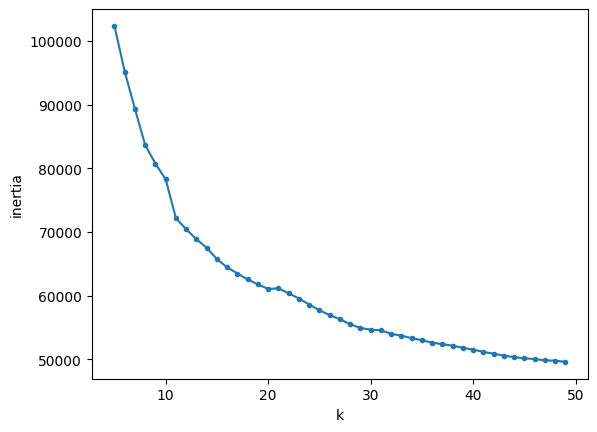

In [57]:
# find the best k for K-Means alg
inertia = []
for k in range(5,50):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

# find an elbow by plotting values of inertia
plt.plot(range(5,50),inertia,'.-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

In [60]:
def draw_pattern(arr):
    row = int(np.ceil(len(arr)/5))
    col = 5
    fig, axs = plt.subplots(row,col,sharex=True, sharey=True)
    plt.tight_layout()
    for i in range(row):
        for j in range(col):
            if i*col + j < len(arr):
                axs[i][j].plot(range(len(arr[col*i+j])), arr[col*i+j])
                axs[i][j].set_title(col*i+j)

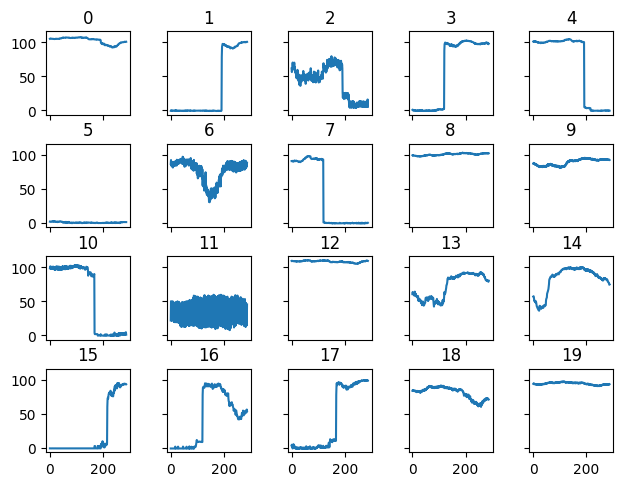

In [61]:
# k=20
km20 = KMeans(n_clusters=20, random_state=42)
km20.fit(data)
# draw cluster centers
draw_pattern(km20.cluster_centers_)

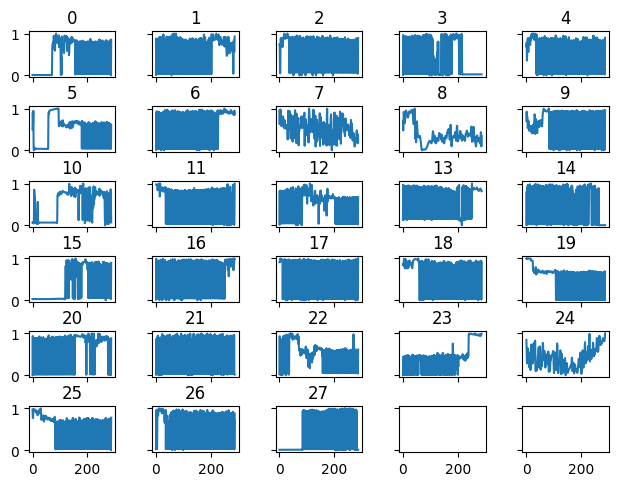

In [62]:
draw_pattern(scaled_data[km20.labels_==11][:30])

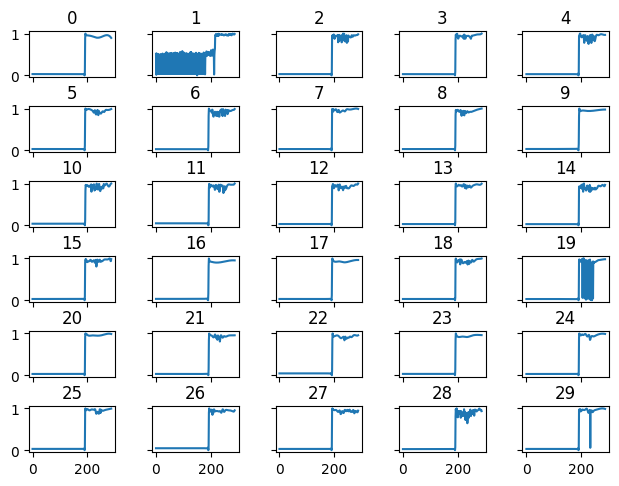

In [64]:
draw_pattern(scaled_data[km20.labels_==1][:30])

# their patterns seem to be unreasonable; supposedly result from missing values
# erase data sets which contain zeros or have some consecutive zeros.

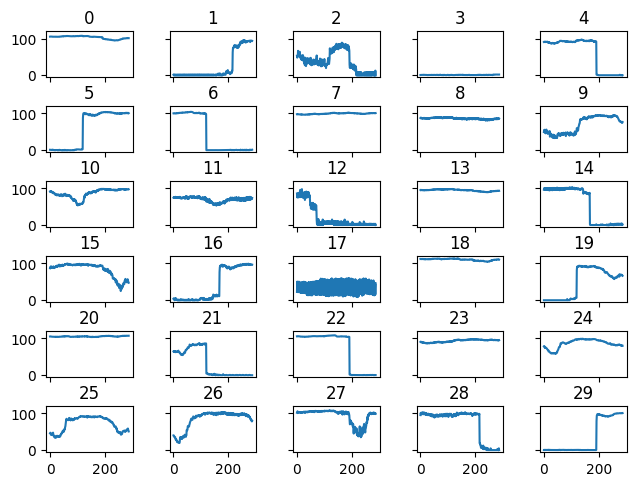

In [63]:
# k=30
km30 = KMeans(n_clusters=30, random_state=42)
km30.fit(data)
# draw cluster centers
draw_pattern(km30.cluster_centers_)

C:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\interpolate\_fitpack_py.py:295: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
C:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\interpolate\_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)


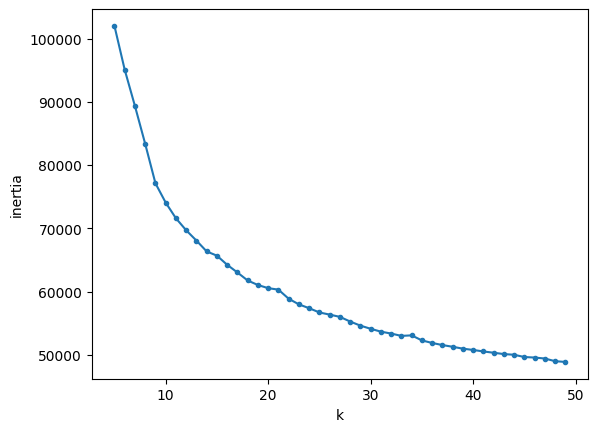

In [69]:
# try different values of s 
data_sp = []
for i in range(len(data)):
    tck = splrep(h, data[i], s=900)
    data_sp.append(BSpline(*tck)(h))

# standardization
scaled_data = []
for i in range(np.shape(data)[0]):
    scaler = MinMaxScaler()
    scaled_data.append(scaler.fit_transform(data_sp[i].reshape(-1,1)))
scaled_data = np.array(scaled_data)
scaled_data = scaled_data.reshape(7047,288)

inertia = []
for k in range(5,50):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

# find an elbow by plotting values of inertia
plt.plot(range(5,50),inertia,'.-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

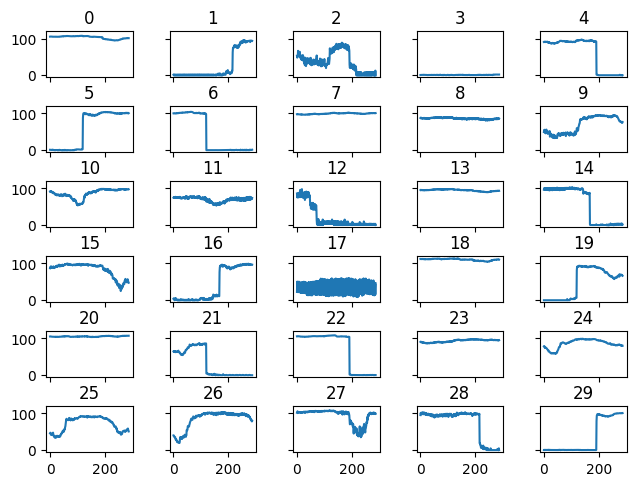

In [70]:
# k=30
km30 = KMeans(n_clusters=30, random_state=42)
km30.fit(data)
# draw cluster centers
draw_pattern(km30.cluster_centers_)

In [77]:
# drop sets having zeros
nonzero_data = []
for i in range(len(data_sp)):
    if np.any(data_sp[i]==0.0):
        continue
    else:
        nonzero_data.append(data_sp[i])

nonzero_data[0]

array([83.73799574, 85.25229023, 86.06897943, 86.32675606, 86.16431279,
       85.72034234, 85.1335374 , 84.54259067, 84.08619484, 83.90304261,
       84.12589913, 84.86381937, 86.03933081, 86.91047862, 86.7863778 ,
       85.39557251, 83.91265389, 83.49183507, 83.75977015, 84.08906347,
       84.36367914, 84.59542124, 84.79609384, 84.977501  , 85.14808526,
       85.30284303, 85.43340919, 85.53141859, 85.58411408, 85.56117035,
       85.42787006, 85.14949585, 84.69133038, 84.04408444, 83.30018133,
       82.57747249, 81.99380937, 81.64060259, 81.50349953, 81.54170676,
       81.71443085, 81.98087837, 82.3002559 , 82.63177   , 82.93462724,
       83.1680342 , 83.30890195, 83.40495963, 83.52164087, 83.68396574,
       83.75530004, 83.60921206, 83.32173436, 83.01951557, 82.8292043 ,
       82.84925781, 83.0653678 , 83.43503458, 83.91575849, 84.46503983,
       85.04037893, 85.59927611, 86.09923169, 86.49774599, 86.76199703,
       86.89787363, 86.92094234, 86.84676967, 86.69092217, 86.46

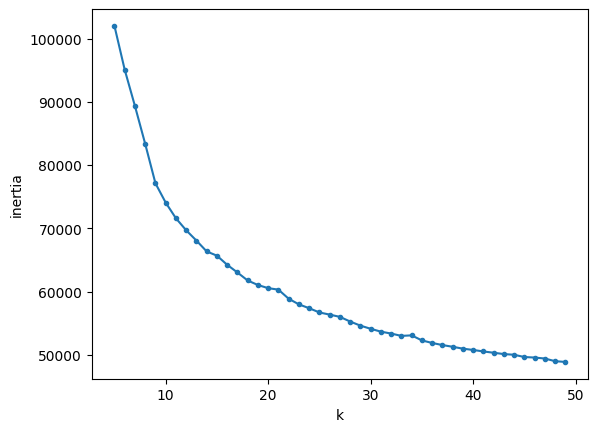

In [78]:
# standardization
scaled_data = []
for i in range(np.shape(data)[0]):
    scaler = MinMaxScaler()
    scaled_data.append(scaler.fit_transform(data_sp[i].reshape(-1,1)))
scaled_data = np.array(scaled_data)
scaled_data = scaled_data.reshape(7047,288)

inertia = []
for k in range(5,50):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

# find an elbow by plotting values of inertia
plt.plot(range(5,50),inertia,'.-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

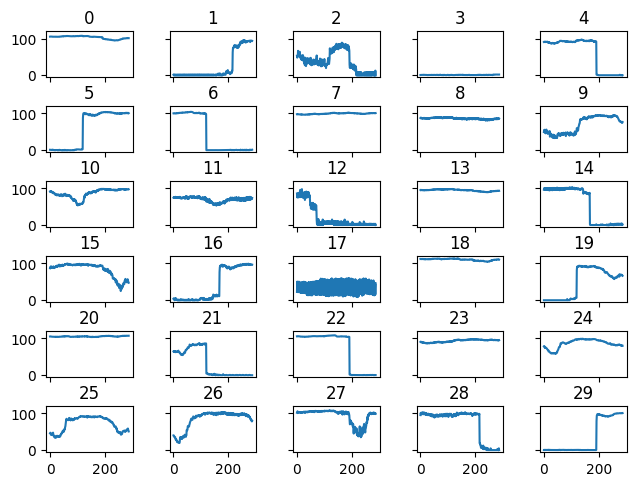

In [79]:
# k=30
km30 = KMeans(n_clusters=30, random_state=42)
km30.fit(data)
# draw cluster centers
draw_pattern(km30.cluster_centers_)